## Abstract embeddings

In [143]:
import numpy as np
import pickle
import json
from typing import List
from dataclasses import dataclass

@dataclass
class Document:
    id: str
    abstract: str
    conclusions: str
    arxiv_id: str
    title: str = None
    score: float = None
    n_citation: int = None
    keywords: List[str] = None

# Load the full embeddings matrix
embeddings = np.load('../data/vector_store/embeddings_matrix.npy')

# Load the index mapping
with open('../data/vector_store/index_mapping.pkl', 'rb') as f:
    index_mapping = pickle.load(f)

# Load the documents
with open('../data/vector_store/documents.pkl', 'rb') as f:
    documents = pickle.load(f)

# Create lists to store the abstract embeddings and corresponding text
abstract_embeddings = []
abstract_texts = []
doc_ids = []

# Iterate through the index mapping to find abstract indices and corresponding text
for doc_id, mappings in index_mapping.items():
    if 'abstract' in mappings:
        abstract_index = mappings['abstract']
        abstract_embeddings.append(embeddings[abstract_index])
        
        # Find the corresponding document and extract the abstract text
        doc = next((d for d in documents if d.id == doc_id), None)
        if doc:
            abstract_texts.append(doc.abstract)
            doc_ids.append(doc_id)
        else:
            print(f"Warning: Document with ID {doc_id} not found.")

# Convert lists to numpy arrays
abstract_embeddings = np.array(abstract_embeddings)

print(f"Processed {len(abstract_embeddings)} abstract embeddings.")
print(f"Shape of abstract embeddings: {abstract_embeddings.shape}")
print(f"Length of abstract texts: {len(abstract_texts)}")
print(f"Length of document IDs: {len(doc_ids)}")

# Save the abstract embeddings
np.save('../data/vector_store/abstract_embeddings.npy', abstract_embeddings)

# Save the abstract texts and document IDs
with open('../data/vector_store/abstract_texts.json', 'w') as f:
    json.dump({
        'doc_ids': doc_ids,
        'abstracts': abstract_texts
    }, f)

print("Saved abstract embeddings and texts.")

Processed 271494 abstract embeddings.
Shape of abstract embeddings: (271494, 1536)
Length of abstract texts: 271494
Length of document IDs: 271494
Saved abstract embeddings and texts.


## Top-k values and indices

In [145]:
import torch
import numpy as np
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset
from topk_sae import FastAutoencoder  # Assuming train.py contains your FastAutoencoder class

# Set grad to false
torch.set_grad_enabled(False)

# hypers
d_model = 1536
n_dirs = d_model * 6
k = 64
auxk = 128
batch_size = 1024

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained model
ae = FastAutoencoder(n_dirs, d_model, k, auxk).to(device)
model_path = 'checkpoints/64_9216_128_auxk_epoch_50.pth'
ae.load_state_dict(torch.load(model_path))
ae.eval()

# Load abstract embeddings
abstract_embeddings = np.load("../data/vector_store/abstract_embeddings.npy")
abstract_embeddings = abstract_embeddings.astype(np.float32)

# Create a DataLoader for efficient batching
dataset = TensorDataset(torch.from_numpy(abstract_embeddings))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Prepare arrays to store results
num_abstracts = len(abstract_embeddings)
topk_indices = np.zeros((num_abstracts, k), dtype=np.int64)
topk_values = np.zeros((num_abstracts, k), dtype=np.float32)

# Process batches
with torch.no_grad():
    for i, (batch,) in enumerate(tqdm(dataloader, desc="Processing abstracts")):
        batch = batch.to(device)
        _, info = ae(batch)
        
        start_idx = i * batch_size
        end_idx = start_idx + batch.size(0)
        
        topk_indices[start_idx:end_idx] = info['topk_indices'].cpu().numpy()
        topk_values[start_idx:end_idx] = info['topk_values'].cpu().numpy()

# Create directory to save results
os.makedirs("sae_data", exist_ok=True)

# Save results
np.save("sae_data/topk_indices.npy", topk_indices)
np.save("sae_data/topk_values.npy", topk_values)

print("Processing complete. Results saved in 'sae_data' folder.")

Processing abstracts: 100%|██████████| 266/266 [00:13<00:00, 19.90it/s]

Processing complete. Results saved in 'sae_data' folder.


# Visualisations

In [146]:
import numpy as np

# Load them
topk_indices = np.load("sae_data/topk_indices.npy")
topk_values = np.load("sae_data/topk_values.npy")

## Log feature density

[0.00366491 0.00296139 0.00693938 ... 0.00183429 0.03692899 0.05308036]
Num features:  9216
Number of non-zero feature densities: 9216


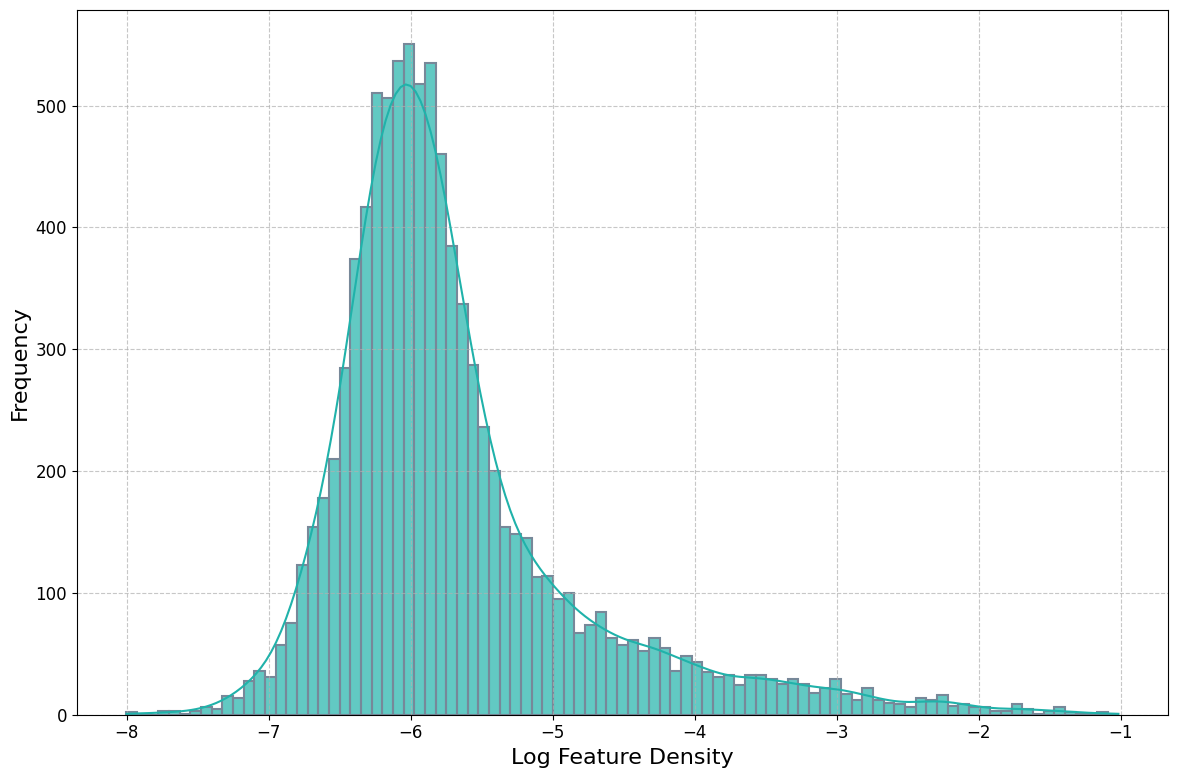

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# hypers
d_model = 1536
n_dirs = d_model * 6
k = 64
auxk = 128
batch_size = 1024

def plot_log_feature_density(topk_indices, save_path=None, dpi=300):
    """
    Create a publication-quality log feature density plot.
    
    :param topk_indices: numpy array of shape (num_samples, k) containing the indices of top-k features
    :param save_path: path to save the figure (if None, the figure will be displayed)
    :param dpi: resolution of the output figure
    """
    # Calculate feature density
    num_samples, k = topk_indices.shape
    num_features = n_dirs
    feature_counts = np.bincount(topk_indices.flatten(), minlength=num_features)
    feature_density = feature_counts / num_samples

    print(feature_density)
    print("Num features: ", num_features)
    # Print non-zero feature density
    print(f"Number of non-zero feature densities: {np.count_nonzero(feature_density)}")
    
    # Calculate log feature density
    log_feature_density = np.log(feature_density + 1e-10)  # Add small constant to avoid log(0)
    
    # Set up the plot style
    #plt.style.use('seaborn-whitegrid')
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    
    # Create custom colormap
    colors = ['#FFA07A', '#20B2AA', '#778899']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the histogram
    sns.histplot(log_feature_density, kde=True, color=colors[1], 
                 edgecolor=colors[2], linewidth=1.5, alpha=0.7, ax=ax)
    
    # Customize the plot
    ax.set_xlabel('Log Feature Density')#, fontweight='bold')
    ax.set_ylabel('Frequency')#, fontweight='bold')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Improve layout
    plt.tight_layout()
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    else:
        plt.show()
    
    plt.close()

# Plot the log feature density
plot_log_feature_density(topk_indices)

Feature 2001 Statistics:
Number of non-zero activations: 1940
Mean: 0.0580
Median: 0.0428
Standard Deviation: 0.0397
Min: 0.0219
Max: 0.2843


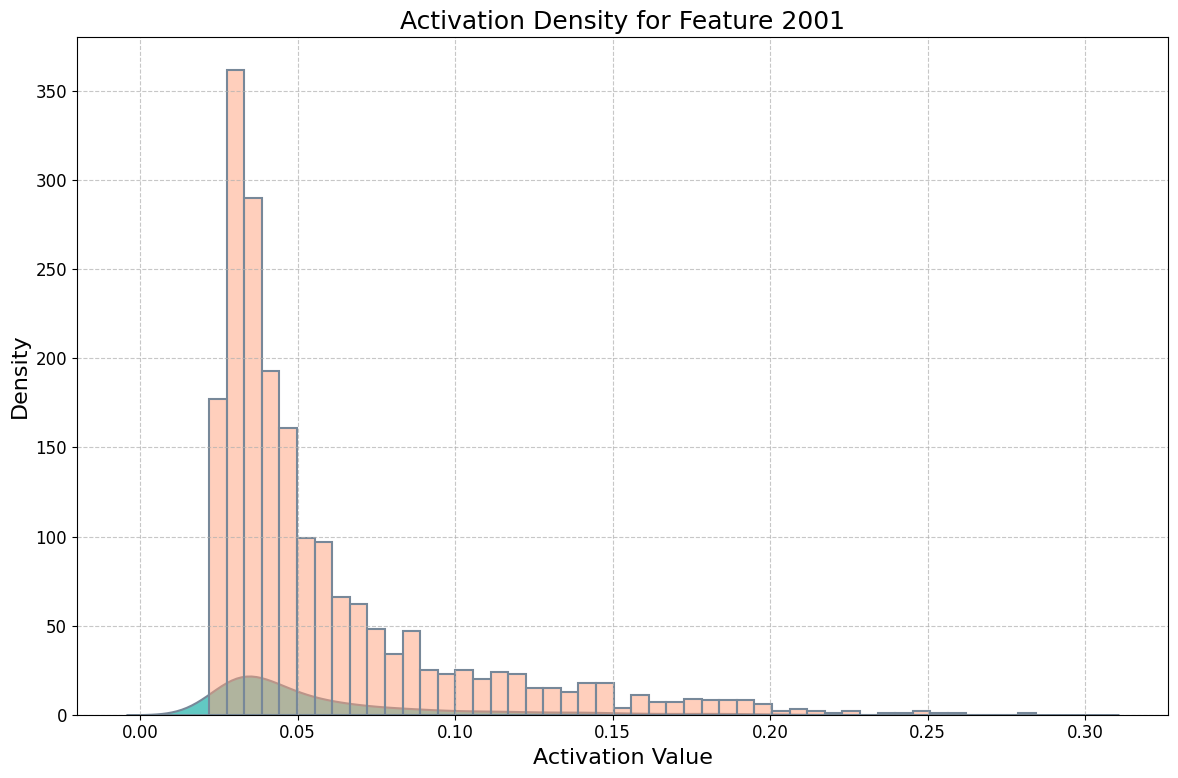

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def plot_feature_activation_density(feature_index, topk_values, topk_indices, save_path=None, dpi=300):
    """
    Create a publication-quality density plot for the activation values of a specific feature.
    
    :param feature_index: Index of the feature to plot
    :param topk_values: numpy array of shape (num_examples, topk) containing the non-zero values for the topk indices
    :param topk_indices: numpy array of shape (num_examples, topk) containing the indices of top-k features
    :param save_path: path to save the figure (if None, the figure will be displayed)
    :param dpi: resolution of the output figure
    """
    # Extract activation values for the specified feature
    feature_mask = topk_indices == feature_index
    activation_values = topk_values[feature_mask]

    # Set up the plot style
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    
    # Create custom colormap
    colors = ['#FFA07A', '#20B2AA', '#778899']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the density
    sns.kdeplot(activation_values, fill=True, color=colors[1], 
                edgecolor=colors[2], linewidth=1.5, alpha=0.7, ax=ax)
    
    # Plot the histogram
    sns.histplot(activation_values, kde=False, color=colors[0], 
                 edgecolor=colors[2], linewidth=1.5, alpha=0.5, ax=ax)
    
    # Customize the plot
    ax.set_xlabel('Activation Value')
    ax.set_ylabel('Density')
    ax.set_title(f'Activation Density for Feature {feature_index}')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Improve layout
    plt.tight_layout()
    
    # Print some statistics
    print(f"Feature {feature_index} Statistics:")
    print(f"Number of non-zero activations: {len(activation_values)}")
    print(f"Mean: {np.mean(activation_values):.4f}")
    print(f"Median: {np.median(activation_values):.4f}")
    print(f"Standard Deviation: {np.std(activation_values):.4f}")
    print(f"Min: {np.min(activation_values):.4f}")
    print(f"Max: {np.max(activation_values):.4f}")
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    else:
        plt.show()
    
    plt.close()

# Example usage:
feature_index = 2001
plot_feature_activation_density(feature_index, topk_values, topk_indices)

In [43]:
import numpy as np
import json
import random

def get_feature_activations(feature_index, m, topk_indices, topk_values, abstract_texts_path, min_length=100):
    """
    Get the top m activating abstracts and m samples of abstracts with zero activation for a given feature,
    ensuring all returned abstracts are greater than min_length characters.
    
    :param feature_index: Index of the feature to analyze
    :param m: Number of top activating abstracts and zero activation samples to return
    :param topk_indices: numpy array of shape (num_abstracts, k) containing the indices of top-k features
    :param topk_values: numpy array of shape (num_abstracts, k) containing the values of top-k features
    :param abstract_texts_path: path to the JSON file containing abstract texts and doc_ids
    :param min_length: minimum length of abstracts to consider (default 100)
    :return: tuple of (top_m_abstracts, zero_activation_samples)
    """
    # Load abstract texts and doc_ids
    with open(abstract_texts_path, 'r') as f:
        abstract_data = json.load(f)
    
    doc_ids = abstract_data['doc_ids']
    abstracts = abstract_data['abstracts']
    
    # Find abstracts where the feature is activated
    feature_mask = topk_indices == feature_index
    activated_indices = np.where(feature_mask.any(axis=1))[0]
    
    # Get the activation values for the feature
    activation_values = np.where(feature_mask, topk_values, 0).max(axis=1)
    
    # Sort activated indices by activation value
    sorted_activated_indices = activated_indices[np.argsort(-activation_values[activated_indices])]
    
    # Get top m activating abstracts with length > min_length
    top_m_abstracts = []
    for i in sorted_activated_indices:
        if len(abstracts[i]) > min_length:
            top_m_abstracts.append((doc_ids[i], abstracts[i], activation_values[i]))
        if len(top_m_abstracts) == m:
            break
    
    # Find abstracts where the feature has zero activation
    zero_activation_indices = np.where(~feature_mask.any(axis=1))[0]
    
    # Randomly sample m abstracts with zero activation and length > min_length
    zero_activation_samples = []
    random.shuffle(list(zero_activation_indices))
    for i in zero_activation_indices:
        if len(abstracts[i]) > min_length:
            zero_activation_samples.append((doc_ids[i], abstracts[i], 0))
        if len(zero_activation_samples) == m:
            break
    
    return top_m_abstracts, zero_activation_samples

# Example usage:
feature_index = 1000
m = 10
topk_indices = np.load("sae_data/topk_indices.npy")
topk_values = np.load("sae_data/topk_values.npy")
abstract_texts_path = "../data/vector_store/abstract_texts.json"

top_abstracts, zero_abstracts = get_feature_activations(feature_index, m, topk_indices, topk_values, abstract_texts_path)

print("Top activating abstracts:")
for doc_id, abstract, activation in top_abstracts:
    #print(f"Doc ID: {doc_id}")
    print(f"Activation: {activation}")
    print(f"{abstract}")  # Print first 100 characters
    print()

print("\n\n\n\nZero activation samples:")
for doc_id, abstract, _ in zero_abstracts:
    #print(f"Doc ID: {doc_id}")
    print(f"{abstract}")  # Print first 100 characters
    print()

Top activating abstracts:
Activation: 0.06926242262125015
We show that within the inverse seesaw mechanism for generating neutrino masses minimal supergravity is more likely to have a sneutrino as the lightest superparticle than the conventional neutralino. We also demonstrate that such schemes naturally reconcile the small neutrino masses with the correct relic sneutrino dark matter abundance and accessible direct detection rates in nuclear recoil experiments. 

Activation: 0.058602817356586456
A new Majoron model is presented within the framework of the seesaw mechanism. Its Higgs sector consists of only doublet representations and the lepton-number violation takes place at the same scale of the electroweak symmetry breaking. This model is different from  the singlet- or triplet-Majoron model in several respects: it is free from the \(\rho\)-parameter constraint and it provides moderately fast neutrino decay, but the constraint from the stellar cooling of red giants is satisfied only

# Autointerp

In [105]:
autointerp_prompt = """ 
You are a meticulous AI and astronomy researcher conducting an important investigation into a certain neuron in a language model trained on astrophysics papers. Your task is to figure out what sort of behaviour this neuron is responsible for -- namely, on what general concepts, features, topics does this neuron fire? Here's how you'll complete the task:

INPUT_DESCRIPTION: 

You will be given two inputs: 1) Max Activating Examples and 2) Zero Activating Examples.

- MAX_ACTIVATING_EXAMPLES_DESCRIPTION
You will be given several examples of text that activate the neuron, along with a number being how much it was activated (these number's absolute scale is meaningless, but the relative scale may be important). This means there is some feature, topic or concept in this text that 'excites' this neuron.

You will also be given several examples of text that doesn't activate the neuron. This means the feature, topic or concept is not present in these texts.

OUTPUT_DESCRIPTION:
Given the inputs provided, complete the following tasks.

Step 1: Based on the MAX_ACTIVATING_EXAMPLES provided, write down potential topics, concepts, and features that they share in common. These will need to be specific - remember, all of the text comes from astronomy, so these need to be highly specific astronomy concepts. You may need to look at different levels of granularity (i.e. subsets of a more general topic). List as many as you can think of. Give higher weight to concepts more present/prominent in examples with higher activations.
Step 2: Based on the zero activating examples, rule out any of the topics/concepts/features listed above that are in the zero-activating examples. Systematically go through your list above.
Step 3: Based on the above two steps, perform a thorough analysis of which feature, concept or topic, at what level of granularity, is likely to activate this neuron. Use Occam's razor, as long as it fits the provided evidence. Be highly rational and analytical here.
Step 4: Based on step 4, summarise this concept in 1-8 words, in the form "FINAL: <explanation>". 

Here are the max-activating examples:

{max_activating_examples}

Here are the zero-activating examples:

{zero_activating_examples}

Work through the steps thoroughly and analytically to interpret our neuron.
"""

In [106]:
m = 10
feature_index = 1000
top_abstracts, zero_abstracts = get_feature_activations(feature_index, m, topk_indices, topk_values, abstract_texts_path)

# Join the abstracts into a single string
max_activating_examples = "\n\n------------------------\n".join([f"Activation:{activation:.3f}\n{abstract}" for _, abstract, activation in top_abstracts])
zero_abstracts = "\n\n------------------------\n".join([abstract for _, abstract, _ in zero_abstracts])

# Create the prompt
prompt = autointerp_prompt.format(max_activating_examples=max_activating_examples, zero_activating_examples=zero_abstracts)



In [107]:
from openai import OpenAI
import yaml

config = yaml.safe_load(open("../config.yaml"))
api_key = config['openai_api_key']

client = OpenAI(
  api_key=api_key,
)

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": prompt}
    ]
)


In [108]:
print(response.choices[0].message.content)

Let's begin the process methodically, step-by-step. 

### Step 1: Identifying Potential Topics, Concepts, and Features

We'll carefully analyze each of the max-activating examples to extract common themes, topics, concepts, and features.

#### Activation: 0.069
The example involves discussions on:
- **Inverse seesaw mechanism for generating neutrino masses**.
- **Neutrino masses and supergravity**.
- **Sneutrino as the lightest superparticle**.
- **Relic sneutrino dark matter abundance**.
- **Direct detection rates in nuclear recoil experiments**.

#### Activation: 0.059
Key points include:
- **New Majoron model within the framework of the seesaw mechanism**.
- **Electroweak symmetry breaking and lepton-number violation**.
- **Constraints from stellar cooling and cosmological/astrophysical constraints**.
- **τ neutrino as heavy as 10 MeV**.

#### Activation: 0.058
This involves:
- **Seesaw mechanism with Majorana neutrinos**.
- **Hierarchical Dirac-type neutrino masses**.
- **Baryogene

In [109]:
interpretation = response.choices[0].message.content.split("FINAL:")[1].strip()
print(f"Interpretation: {interpretation}")

Interpretation: **Neutrino physics and dark matter models**


In [121]:
# Samples to predict
top_abstracts, zero_abstracts = get_feature_activations(feature_index, m*2, topk_indices, topk_values, abstract_texts_path)

# Keep the second k/2 
top_abstracts = top_abstracts[m//2:]
top_abstracts = [abstract for _, abstract, _ in top_abstracts]

zero_abstracts = zero_abstracts[m//2:]

In [127]:
prediction_base_prompt = """
You are an AI expert that is predicting which abstracts will activate a certain neuron in a language model trained on astrophysics papers. 
Your task is to predict which of the following abstracts will activate the neuron the most. Here's how you'll complete the task:

INPUT_DESCRIPTION:
You will be given the description of the type of paper abstracts on which the neuron activates. This description will be short.

You will then be given an abstract. Based on the concept of the abstract, you will predict whether the neuron will activate or not.

OUTPUT_DESCRIPTION:
Given the inputs provided, complete the following tasks.

Step 1: Based on the description of the type of paper abstracts on which the neuron activates, reason step by step about whether the neuron will activate on this abstract or not. Be highly rational and analytical here. The abstract may not be clear cut - it may contain topics/concepts close to the neuron description, but not exact. In this case, reason thoroughly and use your best judgement.
Step 2: Based on the above step, predict whether the neuron will activate on this abstract or not. If you predict it will activate, give a confidence score from 0 to 1 (i.e. 1 if you're certain it will activate because it contains topics/concepts that match the description exactly, 0 if you're highly uncertain). If you predict it will not activate, give a confidence score from -1 to 0.
Step 3: Provide the final prediction in the form "PREDICTION: <number>". Do NOT return anything after this.

Here is the description/interpretation of the type of paper abstracts on which the neuron activates:
{description}

Here is the abstract to predict:
{abstract}

Work through the steps thoroughly and analytically to predict whether the neuron will activate on this abstract.
"""

# Choose a random abstract to predict
#abstract_to_predict = random.choice(top_abstracts)

# # Create the prediction prompt
# prediction_prompt = prediction_base_prompt.format(description=interpretation, abstract=abstract_to_predict)

# prediction_response = client.chat.completions.create(
#     model="gpt-4o",
#     messages=[
#         {"role": "user", "content": prediction_prompt}
#     ]
# )

In [119]:
print(prediction_prompt)


You are an AI expert that is predicting which abstracts will activate a certain neuron in a language model trained on astrophysics papers. 
Your task is to predict which of the following abstracts will activate the neuron the most. Here's how you'll complete the task:

INPUT_DESCRIPTION:
You will be given the description of the type of paper abstracts on which the neuron activates. This description will be short.

You will then be given an abstract. Based on the concept of the abstract, you will predict whether the neuron will activate or not.

OUTPUT_DESCRIPTION:
Given the inputs provided, complete the following tasks.

Step 1: Based on the description of the type of paper abstracts on which the neuron activates, reason step by step about whether the neuron will activate on this abstract or not. Be highly rational and analytical here. The abstract may not be clear cut - it may contain topics/concepts close to the neuron description, but not exact. In this case, reason thoroughly and 

In [120]:
print(prediction_response.choices[0].message.content)

### Step 1:
- **Neuron Description**: The neuron activates on paper abstracts related to "Neutrino physics and dark matter models".
- **Abstract Review**: 
  - The abstract discusses two-body dark matter decays.
  - The products of the decay include a massless and a massive particle.
  - The focus is on cosmological effects, specifically how the slightly warm nature of the massive daughter particle can alleviate discrepancies between different measurements of the Hubble parameter.

**Analysis**:
  - **Dark Matter Models**: The abstract directly involves dark matter decay, which falls under the category of dark matter models.
  - **Neutrino Physics**: The abstract mentions massless and massive particles as decay products. Neutrinos are often massless or nearly massless particles, and while the abstract does not explicitly mention neutrinos, the context of massless particles in dark matter decays could imply relevance to neutrino physics.

### Step 2:
- Based on the abstract's focus on d

In [130]:
from tqdm import tqdm

# Samples to predict
m = 10
top_abstracts, zero_abstracts = get_feature_activations(feature_index, m*2, topk_indices, topk_values, abstract_texts_path)

# Keep the second k/2 
top_abstracts = [abstract for _, abstract, _ in top_abstracts]
top_abstracts = top_abstracts[m:]
print(f'{len(top_abstracts)} top abstracts')

zero_abstracts = zero_abstracts[m:]
print(f'{len(zero_abstracts)} zero abstracts')

# Go through all top abstracts and all zero abstracts and predict
predictions = []
ground_truth = [1] * len(top_abstracts) + [0] * len(zero_abstracts)

for abstract in tqdm(top_abstracts + zero_abstracts):
    prediction_prompt = prediction_base_prompt.format(description=interpretation, abstract=abstract)

    prediction_response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": prediction_prompt}
        ]
    )

    prediction = prediction_response.choices[0].message.content.split("PREDICTION:")[1].strip()
    # Remove '*' from the prediction
    prediction = prediction.replace("*", "")
    print(f"Prediction: {prediction}")
    predictions.append(float(prediction))

10 top abstracts
10 zero abstracts


  5%|▌         | 1/20 [00:05<01:40,  5.27s/it]

Prediction: 0.9


 10%|█         | 2/20 [00:10<01:31,  5.10s/it]

Prediction: 0.9


 15%|█▌        | 3/20 [00:13<01:14,  4.41s/it]

Prediction: 0.7


 20%|██        | 4/20 [00:38<03:16, 12.25s/it]

Prediction: 0.9


 25%|██▌       | 5/20 [01:04<04:21, 17.44s/it]

Prediction: 0.9


 30%|███       | 6/20 [01:30<04:42, 20.19s/it]

Prediction: 1


 35%|███▌      | 7/20 [01:37<03:25, 15.84s/it]

Prediction: 0.9


 40%|████      | 8/20 [02:02<03:45, 18.77s/it]

Prediction: 0.7


 45%|████▌     | 9/20 [02:26<03:45, 20.50s/it]

Prediction: 1


 50%|█████     | 10/20 [02:50<03:37, 21.73s/it]

Prediction: 1


 55%|█████▌    | 11/20 [02:59<02:39, 17.71s/it]

Prediction: -1


 60%|██████    | 12/20 [03:26<02:44, 20.52s/it]

Prediction: -0.8


 65%|██████▌   | 13/20 [03:51<02:33, 21.92s/it]

Prediction: -1


 70%|███████   | 14/20 [03:58<01:43, 17.22s/it]

Prediction: -1


 75%|███████▌  | 15/20 [04:26<01:43, 20.67s/it]

Prediction: -0.8


 80%|████████  | 16/20 [04:51<01:27, 21.85s/it]

Prediction: -0.9


 85%|████████▌ | 17/20 [04:55<00:49, 16.50s/it]

Prediction: -0.8


 90%|█████████ | 18/20 [05:21<00:38, 19.40s/it]

Prediction: -0.9


 95%|█████████▌| 19/20 [05:47<00:21, 21.27s/it]

Prediction: -1


100%|██████████| 20/20 [06:13<00:00, 18.67s/it]

Prediction: -1


In [136]:
# Calculate metrics - Pearson correlation, F1

# Pearson correlation
from scipy.stats import pearsonr

correlation, _ = pearsonr(ground_truth, predictions)

print(f"Pearson correlation: {correlation}")

# F1 score
from sklearn.metrics import f1_score

# Convert predictions to binary
binary_predictions = [1 if p > 0 else 0 for p in predictions]

f1 = f1_score(ground_truth, binary_predictions)

print(f"F1 score: {f1}")

Pearson correlation: 0.9944004281595773
F1 score: 1.0


## Refactor autointerp

In [ ]:
from openai import OpenAI
import yaml
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import f1_score

# Load them
topk_indices = np.load("sae_data/topk_indices.npy")
topk_values = np.load("sae_data/topk_values.npy")

abstract_texts_path = "../data/vector_store/abstract_texts.json"

autointerp_prompt = """ 
You are a meticulous AI and astronomy researcher conducting an important investigation into a certain neuron in a language model trained on astrophysics papers. Your task is to figure out what sort of behaviour this neuron is responsible for -- namely, on what general concepts, features, topics does this neuron fire? Here's how you'll complete the task:

INPUT_DESCRIPTION: 

You will be given two inputs: 1) Max Activating Examples and 2) Zero Activating Examples.

- MAX_ACTIVATING_EXAMPLES_DESCRIPTION
You will be given several examples of text that activate the neuron, along with a number being how much it was activated (these number's absolute scale is meaningless, but the relative scale may be important). This means there is some feature, topic or concept in this text that 'excites' this neuron.

You will also be given several examples of text that doesn't activate the neuron. This means the feature, topic or concept is not present in these texts.

OUTPUT_DESCRIPTION:
Given the inputs provided, complete the following tasks.

Step 1: Based on the MAX_ACTIVATING_EXAMPLES provided, write down potential topics, concepts, and features that they share in common. These will need to be specific - remember, all of the text comes from astronomy, so these need to be highly specific astronomy concepts. You may need to look at different levels of granularity (i.e. subsets of a more general topic). List as many as you can think of. Give higher weight to concepts more present/prominent in examples with higher activations.
Step 2: Based on the zero activating examples, rule out any of the topics/concepts/features listed above that are in the zero-activating examples. Systematically go through your list above.
Step 3: Based on the above two steps, perform a thorough analysis of which feature, concept or topic, at what level of granularity, is likely to activate this neuron. Use Occam's razor, as long as it fits the provided evidence. Be highly rational and analytical here.
Step 4: Based on step 4, summarise this concept in 1-8 words, in the form "FINAL: <explanation>". 

Here are the max-activating examples:

{max_activating_examples}

Here are the zero-activating examples:

{zero_activating_examples}

Work through the steps thoroughly and analytically to interpret our neuron.
"""

config = yaml.safe_load(open("../config.yaml"))
api_key = config['openai_api_key']

client = OpenAI(
  api_key=api_key,
)

m = 10
feature_index = 1000
top_abstracts, zero_abstracts = get_feature_activations(feature_index, m, topk_indices, topk_values, abstract_texts_path)

# Join the abstracts into a single string
max_activating_examples = "\n\n------------------------\n".join([f"Activation:{activation:.3f}\n{abstract}" for _, abstract, activation in top_abstracts])
zero_abstracts = "\n\n------------------------\n".join([abstract for _, abstract, _ in zero_abstracts])

# Create the prompt
prompt = autointerp_prompt.format(max_activating_examples=max_activating_examples, zero_activating_examples=zero_abstracts)

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": prompt}
    ]
)

interpretation = response.choices[0].message.content.split("FINAL:")[1].strip()
print(f"Interpretation: {interpretation}")

# Samples to predict
top_abstracts, zero_abstracts = get_feature_activations(feature_index, m*2, topk_indices, topk_values, abstract_texts_path)

# Keep the second k/2 
top_abstracts = top_abstracts[m//2:]
top_abstracts = [abstract for _, abstract, _ in top_abstracts]

zero_abstracts = zero_abstracts[m//2:]

prediction_base_prompt = """
You are an AI expert that is predicting which abstracts will activate a certain neuron in a language model trained on astrophysics papers. 
Your task is to predict which of the following abstracts will activate the neuron the most. Here's how you'll complete the task:

INPUT_DESCRIPTION:
You will be given the description of the type of paper abstracts on which the neuron activates. This description will be short.

You will then be given an abstract. Based on the concept of the abstract, you will predict whether the neuron will activate or not.

OUTPUT_DESCRIPTION:
Given the inputs provided, complete the following tasks.

Step 1: Based on the description of the type of paper abstracts on which the neuron activates, reason step by step about whether the neuron will activate on this abstract or not. Be highly rational and analytical here. The abstract may not be clear cut - it may contain topics/concepts close to the neuron description, but not exact. In this case, reason thoroughly and use your best judgement.
Step 2: Based on the above step, predict whether the neuron will activate on this abstract or not. If you predict it will activate, give a confidence score from 0 to 1 (i.e. 1 if you're certain it will activate because it contains topics/concepts that match the description exactly, 0 if you're highly uncertain). If you predict it will not activate, give a confidence score from -1 to 0.
Step 3: Provide the final prediction in the form "PREDICTION: <number>". Do NOT return anything after this.

Here is the description/interpretation of the type of paper abstracts on which the neuron activates:
{description}

Here is the abstract to predict:
{abstract}

Work through the steps thoroughly and analytically to predict whether the neuron will activate on this abstract.
"""

# Samples to predict
num_to_predict = 5
top_abstracts, zero_abstracts = get_feature_activations(feature_index, m*2, topk_indices, topk_values, abstract_texts_path)

# Keep the second k/2 
top_abstracts = [abstract for _, abstract, _ in top_abstracts]
top_abstracts = top_abstracts[-num_to_predict:]
print(f'{len(top_abstracts)} top abstracts')

zero_abstracts = zero_abstracts[-num_to_predict:]
print(f'{len(zero_abstracts)} zero abstracts')

# Go through all top abstracts and all zero abstracts and predict
predictions = []
ground_truth = [1] * len(top_abstracts) + [0] * len(zero_abstracts)

for abstract in tqdm(top_abstracts + zero_abstracts):
    prediction_prompt = prediction_base_prompt.format(description=interpretation, abstract=abstract)

    prediction_response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": prediction_prompt}
        ]
    )

    prediction = prediction_response.choices[0].message.content.split("PREDICTION:")[1].strip()
    # Remove '*' from the prediction
    prediction = prediction.replace("*", "")
    print(f"Prediction: {prediction}")
    predictions.append(float(prediction))

correlation, _ = pearsonr(ground_truth, predictions)

print(f"Pearson correlation: {correlation}")

# F1 score

# Convert predictions to binary
binary_predictions = [1 if p > 0 else 0 for p in predictions]

f1 = f1_score(ground_truth, binary_predictions)

print(f"F1 score: {f1}")

In [140]:
# Samples to predict
num_to_predict = 5
top_abstracts, zero_abstracts = get_feature_activations(feature_index, m*2, topk_indices, topk_values, abstract_texts_path)

# Keep the second k/2 
top_abstracts = [abstract for _, abstract, _ in top_abstracts]
top_abstracts = top_abstracts[-num_to_predict:]
print(f'{len(top_abstracts)} top abstracts')

zero_abstracts = zero_abstracts[-num_to_predict:]
print(f'{len(zero_abstracts)} zero abstracts')

# Go through all top abstracts and all zero abstracts and predict
predictions = []
ground_truth = [1] * len(top_abstracts) + [0] * len(zero_abstracts)

for abstract in tqdm(top_abstracts + zero_abstracts):
    prediction_prompt = prediction_base_prompt.format(description=interpretation, abstract=abstract)

    prediction_response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prediction_prompt}
        ]
    )

    prediction = prediction_response.choices[0].message.content.split("PREDICTION:")[1].strip()
    # Remove '*' from the prediction
    prediction = prediction.replace("*", "")
    print(f"Prediction: {prediction}")
    predictions.append(float(prediction))

correlation, _ = pearsonr(ground_truth, predictions)

print(f"Pearson correlation: {correlation}")

# F1 score

# Convert predictions to binary
binary_predictions = [1 if p > 0 else 0 for p in predictions]

f1 = f1_score(ground_truth, binary_predictions)

print(f"F1 score: {f1}")

5 top abstracts
5 zero abstracts


 10%|█         | 1/10 [00:03<00:31,  3.47s/it]

ChatCompletion(id='chatcmpl-9jAxe3QUX6lzGD0Q9Ol1nYXFbfBrh', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Step 1: \nThe abstract mentions the type II seesaw mechanism for neutrino masses, which is related to the "Neutrino Seesaw Mechanism" part of the neuron description. Additionally, it discusses dark matter in the form of an unstable gravitino, which is related to the "Dark Matter" aspect of the neuron description. The abstract also talks about providing a natural explanation for certain experimental results and explaining neutrino masses without high scale physics, which are topics generally related to astrophysics.\n\nStep 2:\nGiven that the abstract covers topics related to both the Neutrino Seesaw Mechanism and Dark Matter, and also touches on other aspects relevant to astrophysics, it is highly likely that the neuron will activate on this abstract. I am confident in this prediction.\n\nPREDICTION: 1.0', role='assistant', fun

 20%|██        | 2/10 [00:07<00:28,  3.59s/it]

ChatCompletion(id='chatcmpl-9jAxhhBsx9ETncQEe7Cs1NDDTKl43', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Step 1: The description of the type of paper abstracts on which the neuron activates includes the "Neutrino Seesaw Mechanism & Dark Matter." The abstract mentions light Majorana neutrinos and their right-handed counterparts in the context of a seesaw mechanism, which is relevant to the concept of the Neutrino Seesaw Mechanism. Additionally, the abstract discusses cosmological baryon number asymmetry, which could be related to dark matter indirectly. Overall, the abstract touches upon topics related to neutrinos and cosmology, which align with the neuron\'s activation description.\n\nStep 2: Based on the analysis above, I predict that the neuron will activate on this abstract with a moderate confidence score of 0.6. While the abstract discusses relevant topics related to the Neutrino Seesaw Mechanism and cosmology, it does not e

 30%|███       | 3/10 [00:09<00:22,  3.25s/it]

ChatCompletion(id='chatcmpl-9jAxlLtWGmxn4rje57Oq97hDrRsdN', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Step 1:\nThe description provided mentions the "Neutrino Seesaw Mechanism & Dark Matter". The abstract talks about a toy-model of matter bounce with two fermion species and a curvaton mechanism. It also mentions baryogenesis and constraints on dark matter particles.\n\nThe mention of fermion species and dark matter particles align with the neuron description. However, the abstract does not explicitly mention the Neutrino Seesaw Mechanism. It does discuss related topics such as curvaton mechanism and baryogenesis, which may activate the neuron to some extent.\n\nStep 2:\nGiven that the abstract contains relevant topics such as fermion species and dark matter particles, but does not explicitly mention the Neutrino Seesaw Mechanism, I predict with medium confidence that the neuron will activate on this abstract. \nConfidence score

 40%|████      | 4/10 [00:12<00:17,  2.98s/it]

ChatCompletion(id='chatcmpl-9jAxoiZ379xKWWfGXT8ISRFiVTa58', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Step 1: The abstract discusses the concept of sterile neutrinos as a dark matter candidate, which is related to the "Neutrino Seesaw Mechanism & Dark Matter" description. It talks about different mechanisms for sterile neutrino dark matter production, including the Dodelson-Widrow mechanism and the freeze-in mechanism. It also reviews motivations for such frameworks and their phenomenological signatures.\n\nStep 2: Given that the abstract directly discusses sterile neutrinos as dark matter candidates and various mechanisms for their production, it aligns closely with the description of the neuron that activates on papers related to the "Neutrino Seesaw Mechanism & Dark Matter." Therefore, it is likely that the neuron will activate on this abstract.\n\nConfidence Score: 0.9\n\nPREDICTION: 1', role='assistant', function_call=None

 50%|█████     | 5/10 [00:15<00:14,  2.88s/it]

ChatCompletion(id='chatcmpl-9jAxrqTinW1dwPLOyDk7jQhkycf5N', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Step 1: The abstract discusses the inverse Seesaw scenario for neutrino masses, Lepton number symmetry, Majoron associated with spontaneous symmetry breaking, sterile neutrinos at the keV-MeV scale, and their potential role as dark matter. While the abstract does not explicitly mention the "Neutrino Seesaw Mechanism & Dark Matter" in the description, it covers related concepts such as neutrino masses, symmetry breaking, and dark matter components in the Universe. Therefore, there are significant overlaps with the neuron\'s description.\n\nStep 2: Considering the overlap between the abstract content and the neuron description, I predict that the neuron will activate on this abstract with a relatively high confidence level. The abstract covers topics closely related to the neuron\'s activation criteria, even though it does not di

 60%|██████    | 6/10 [00:18<00:12,  3.15s/it]

ChatCompletion(id='chatcmpl-9jAxtzNFa8UQyvSArlr9xafExXukl', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Step 1: The abstract discusses the X-ray variability of a particular object based on ASCA observatory data. It mentions the power spectrum of the object in a certain frequency range, with a flat portion in the spectrum at specific frequencies. It also talks about periodic variability dominating over stochastic variability at lower frequencies and mentions a model that best fits the observations. There is a mention of jet nutation and the suggestion that the power spectrum may not reflect the disk structure at certain frequencies.\n\nStep 2: The abstract does not directly mention the Neutrino Seesaw Mechanism or Dark Matter. It focuses on X-ray variability of an object, which is not directly related to these topics. The topics discussed in the abstract do not have a clear connection to the description of the neuron activation, w

 70%|███████   | 7/10 [00:22<00:10,  3.35s/it]

ChatCompletion(id='chatcmpl-9jAxxov8cP2xt2k99McysomoV734J', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Step 1: The abstract discusses the instability of the $f$-mode in neutron stars, driven by the emission of gravitational waves. It also talks about the coupling of the parent mode with pairs of daughter modes, exhibiting a variety of behaviors. The study focuses on neutron stars derived from supernovae and mergers, modeled as polytropes in a Newtonian context. There is no direct mention of the Neutrino Seesaw Mechanism or Dark Matter in this abstract.\n\nStep 2: Based on the analysis in Step 1, the abstract does not directly relate to the Neutrino Seesaw Mechanism or Dark Matter. While the concept of neutron stars is somewhat related to astrophysics, the specific topics described in the abstract do not align with the activation criteria of the neuron. Therefore, I predict that the neuron will not activate on this abstract.\n\nS

 80%|████████  | 8/10 [00:25<00:06,  3.33s/it]

ChatCompletion(id='chatcmpl-9jAy14f4btqsXQrSR2WmUpdRplNn3', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Step 1: The abstract discusses the construction of a model for the inner crust of neutron stars using interactions from chiral effective field theory to calculate its equation of state, shear properties, and the spectrum of crustal shear modes. It also mentions studying uncertainties associated with nuclear physics input, crust composition, and neutron entrainment.\n\nWhile the abstract does mention neutron stars and nuclear physics, it does not directly discuss the Neutrino Seesaw Mechanism or Dark Matter. The focus is more on the properties of neutron stars and the calculations related to their crust. However, the topic of neutrinos or dark matter is not the central theme of this abstract.\n\nStep 2: Based on the analysis in Step 1, it is unlikely that this abstract will activate the neuron related to the Neutrino Seesaw Mech

 90%|█████████ | 9/10 [00:28<00:03,  3.10s/it]

ChatCompletion(id='chatcmpl-9jAy4OKOpFZr0H7ADccCxjNEwlJ4G', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Step 1: \nThe abstract discusses the formation of planetary systems around Proxima Centauri, Alpha Centauri A, and Alpha Centauri B, which are all stars in the Alpha Centauri system. It mentions N-body simulations to determine the plausibility of the scenario and the implications for planet formation in this system. The abstract does not explicitly mention the Neutrino Seesaw Mechanism or Dark Matter, which are the key concepts the neuron activates on. However, the abstract does focus on astrophysical phenomena and the dynamics of planetary formation, which are related to the field of astrophysics.\n\nStep 2:\nGiven that the abstract does not directly mention the Neutrino Seesaw Mechanism or Dark Matter, the relevance of the content to the neuron's activation is not clear. However, since the abstract deals with astrophysical si

100%|██████████| 10/10 [00:31<00:00,  3.11s/it]

ChatCompletion(id='chatcmpl-9jAy73FIwvFPE8Bcf0fvEzWfh1Hsk', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Step 1: The description of the neuron's activation indicates an interest in the Neutrino Seesaw Mechanism and Dark Matter. The abstract provided, however, focuses on the Cosmic Web Detachment (CWD) model in the context of galaxy evolution and star formation. While the abstract touches on cosmological processes and interactions, it does not directly mention neutrinos or dark matter. \n\nThe CWD model discusses the impact of cosmic web interactions on star-forming galaxies, including quenching mechanisms such as gas stripping, harassment, strangulation, and starvation. These mechanisms are driven by gravitational and mechanical processes, rather than neutrinos or dark matter.\n\nGiven that the abstract does not explicitly mention the Neutrino Seesaw Mechanism or Dark Matter, it is unlikely that the neuron will activate strongly b